# 03 — LBO Sensitivity & Value Creation

**Goal.** Build a lightweight LBO model to show how **multiple, leverage, and operations** drive **MoIC and IRR**.  
We’ll:
1) Set a baseline P&L and leverage.
2) Compute equity returns (MoIC, IRR).
3) Visualize **value creation waterfall**.
4) Run **two-way sensitivity** heatmaps.
5) Show **driver tornado** and **Monte Carlo** IRR distribution.

> Simple, transparent scaffolding — perfect for board/executive discussions; can be extended with detailed cash flow.

In [28]:
# Easy fix for finding parent directory modules
import sys, os
sys.path.append(os.path.abspath(".."))

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (8,4),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25
})

In [30]:
# Base operating snapshot (Year 0)
sales0      = 200_000            # Annual sales
ebitda0     = 58_000             # 29% margin
ebitda_mg0  = ebitda0 / sales0

# Operating improvements (absolute and rate changes)
price_vol_mix   = 18_576         # positive = uplift to EBITDA
cogs_pct_delta  = -0.015         # reduce COGS % by 1.5 pp -> EBITDA up
opex_delta      = -1_260         # lower opex (positive impact on EBITDA = +1,260)

# Financing & deal structure
entry_mult  = 8.5                # EV / EBITDA at entry
net_debt    = 0.6                # Debt / EV at entry (60% debt)
cash_rate   = 0.0                # no excess cash assumed
cost_of_debt= 0.08               # 8% cash interest
term_years  = 5

# Capex & working capital as % of sales
capex_pct   = 0.03               # 3% of sales
nwc_pct     = 0.12               # working capital / sales (for delta, we’ll assume modest improvement)

# Growth and margin shift through hold
sales_cagr  = 0.05               # 5% CAGR
mg_uplift   = 0.02               # +200 bps EBITDA margin improvement by Yr 5 (linear ramp)

exit_mult   = 9.5                # Exit EV/EBITDA
tax_rate    = 0.25               # Simplified tax on EBT (cash taxes)

In [31]:
def ramp(start, end, T):
    """Linear ramp from start to end over T years (inclusive of end)."""
    return np.linspace(start, end, T+1)

def project_pnl(sales0, ebitda_mg0, sales_cagr, mg_uplift, T=5):
    sales = [sales0]
    for _ in range(T):
        sales.append(sales[-1]*(1+sales_cagr))
    sales = np.array(sales)
    mg_path = ramp(ebitda_mg0, ebitda_mg0+mg_uplift, T)
    ebitda = sales * mg_path
    return pd.DataFrame({"year": np.arange(T+1), "sales": sales, "ebitda": ebitda, "margin": mg_path})

def value_creation_walk(ebitda0, price_vol_mix, cogs_pct_delta, opex_delta, sales0):
    """
    Return steps for a simple EBITDA bridge.
    cogs_pct_delta is a change in COGS% (negative => improves EBITDA).
    opex_delta is absolute reduction in opex (positive EBITDA impact).
    """
    delta_cogs = -cogs_pct_delta * sales0   # if cogs% goes down, EBITDA increases
    steps = [
        ("Base EBITDA", ebitda0),
        ("Price/Vol/Mix", price_vol_mix),
        ("COGS%", delta_cogs),
        ("Opex", -opex_delta if opex_delta < 0 else opex_delta),  # sign as EBITDA delta
    ]
    values = [ebitda0]
    for label, delta in steps[1:]:
        values.append(values[-1] + delta)
    df = pd.DataFrame({
        "step": [s[0] for s in steps] + ["New EBITDA"],
        "value": values + [values[-1]]
    })
    return df, values[-1]

def equity_returns(entry_mult, ebitda0, exit_mult, ebitda_T, debt_in, rate, T, taxes=0.25,
                   capex_pct=0.03, sales_path=None, nwc_pct=0.12):
    """
    Very compact LBO return logic with interest-only debt & no amortization (for clarity).
    You can extend to amortizing schedules easily.

    Cash flows to equity:
      CF0 = -Equity_in
      CF1..T = EBITDA - interest - capex - ΔNWC - taxes
      Exit: Equity_out = EV_exit - Debt_out (assume same principal outstanding)

    Returns MoIC and IRR.
    """
    EV0 = entry_mult * ebitda0
    debt = debt_in * EV0
    equity = EV0 - debt

    # Period flows
    if sales_path is None:
        sales_path = np.full(T, sales0)

    ebitda_path = np.linspace(ebitda0, ebitda_T, T+1)[1:]  # 1..T
    interest    = np.full(T, debt * rate)
    capex       = capex_pct * sales_path
    # Simple ΔNWC to reach nwc_pct * sales each year (Δ from prior)
    nwc_level   = nwc_pct * sales_path
    nwc_delta   = np.r_[nwc_level[0], np.diff(nwc_level)]  # first year builds level, then changes

    ebt         = ebitda_path - interest - capex - nwc_delta
    cash_taxes  = np.clip(ebt, 0, None) * taxes
    fcf_to_equity = ebt - cash_taxes

    # Exit
    EV_exit = exit_mult * ebitda_T
    equity_exit = EV_exit - debt  # no amortization version

    # Equity CFs
    cfs = np.r_[-equity, fcf_to_equity[:-1], fcf_to_equity[-1] + equity_exit]
    times = np.arange(cfs.size)

    # IRR & MoIC
    def xirr(cashflows, times):
        # Newton step
        r = 0.2
        for _ in range(100):
            denom = (1+r)**times
            f = np.sum(cashflows/denom)
            df = np.sum(-times*cashflows/denom/(1+r))
            if abs(f) < 1e-9:
                break
            r = max(-0.999, r - f/df)
        return r

    irr = xirr(cfs, times)
    moic = (cfs.sum() + equity) / equity
    return dict(MoIC=moic, IRR=irr, EV0=EV0, Equity=equity, Debt=debt,
                cfs=cfs, sales_path=sales_path, ebitda_path=ebitda_path)

In [32]:
bridge_df, ebitda1 = value_creation_walk(ebitda0, price_vol_mix, cogs_pct_delta, opex_delta, sales0)
bridge_df

,step,value
0,Base EBITDA,58000.0
1,Price/Vol/Mix,76576.0
2,COGS%,79576.0
3,Opex,80836.0
4,New EBITDA,80836.0


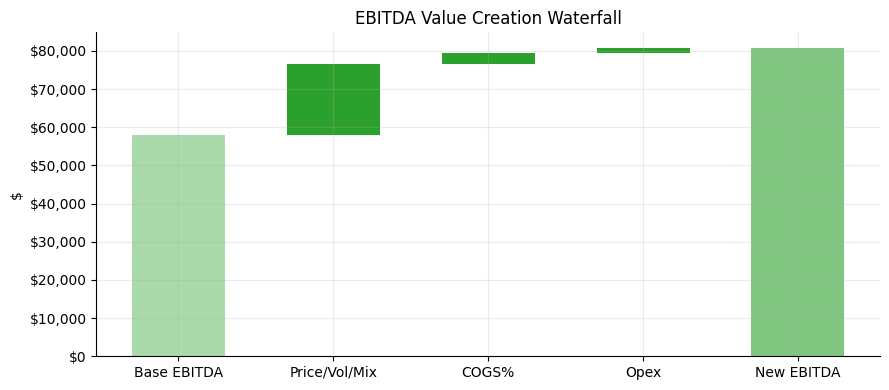

In [33]:
import matplotlib.ticker as mtick

labels = ["Price/Vol/Mix", "COGS%", "Opex"]
deltas = np.array([18576.0, 3000.0, 1260.0])  # from your steps
cum = np.r_[ebitda0, ebitda0 + np.cumsum(deltas)]
tops = ebitda0 + np.cumsum(deltas)

plt.figure(figsize=(9,4))
# baseline as a thin reference bar
plt.bar(["Base EBITDA"], [ebitda0], width=0.6, color="#2ca02c63", alpha=0.4)
# delta bars
for i, (lab, d) in enumerate(zip(labels, deltas), start=1):
    color = "#2ca02c" if d >= 0 else "#d62728"
    plt.bar([lab], [d], bottom=[cum[i-1]], width=0.6, color=color)
# final total
plt.bar(["New EBITDA"], [cum[-1]], width=0.6, color="#2ca02c63", alpha=0.6)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.title("EBITDA Value Creation Waterfall")
plt.ylabel("$")
plt.tight_layout(); plt.show()

In [34]:
pnl = project_pnl(sales0, ebitda_mg0, sales_cagr, mg_uplift, T=term_years)
pnl.head(), pnl.tail()

(   year      sales      ebitda  margin
 0     0  200000.00  58000.0000   0.290
 1     1  210000.00  61740.0000   0.294
 2     2  220500.00  65709.0000   0.298
 3     3  231525.00  69920.5500   0.302
 4     4  243101.25  74388.9825   0.306,
    year        sales        ebitda  margin
 1     1  210000.0000  61740.000000   0.294
 2     2  220500.0000  65709.000000   0.298
 3     3  231525.0000  69920.550000   0.302
 4     4  243101.2500  74388.982500   0.306
 5     5  255256.3125  79129.456875   0.310)

In [35]:
sales_path = pnl["sales"].iloc[1:].to_numpy()                # Years 1..T
ebitda_T   = pnl["ebitda"].iloc[-1]                          # Exit EBITDA

ret = equity_returns(entry_mult, ebitda1, exit_mult, ebitda_T,
                     debt_in=net_debt, rate=cost_of_debt, T=term_years,
                     taxes=tax_rate, capex_pct=capex_pct,
                     sales_path=sales_path, nwc_pct=nwc_pct)

print(f"Entry EV: ${ret['EV0']:,.0f}  | Equity: ${ret['Equity']:,.0f}  | Debt: ${ret['Debt']:,.0f}")
print(f"MoIC: {ret['MoIC']:.2f}x  | IRR: {ret['IRR']*100:.1f}%")
ret["cfs"]

Entry EV: $687,106  | Equity: $274,842  | Debt: $412,264
MoIC: 1.70x  | IRR: 12.6%


array([-274842.4       ,   12010.20253125,   29472.9710625 ,
         28921.67709375,   28355.6175    ,  367240.2943125 ])

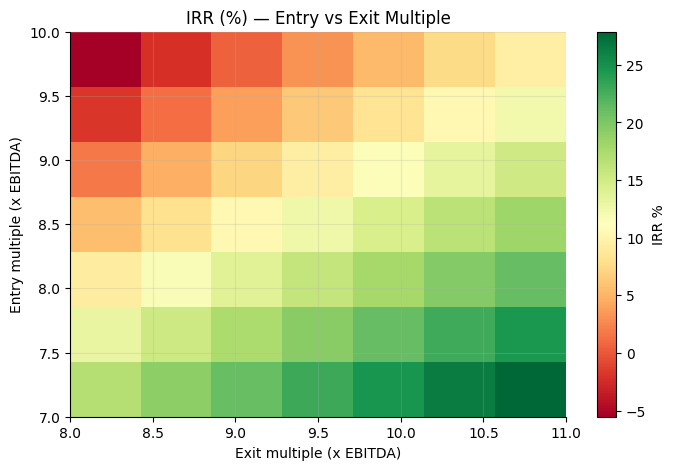

In [36]:
entry_grid = np.arange(7.0, 10.5, 0.5)
exit_grid  = np.arange(8.0, 11.5, 0.5)

Z = np.zeros((len(entry_grid), len(exit_grid)))
for i, em in enumerate(entry_grid):
    for j, xm in enumerate(exit_grid):
        r = equity_returns(em, ebitda1, xm, ebitda_T,
                           debt_in=net_debt, rate=cost_of_debt, T=term_years,
                           taxes=tax_rate, capex_pct=capex_pct,
                           sales_path=sales_path, nwc_pct=nwc_pct)
        Z[i,j] = r["IRR"]*100

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(Z, origin="lower", cmap="RdYlGn", extent=[exit_grid[0], exit_grid[-1], entry_grid[0], entry_grid[-1]], aspect="auto")
ax.set_xlabel("Exit multiple (x EBITDA)")
ax.set_ylabel("Entry multiple (x EBITDA)")
ax.set_title("IRR (%) — Entry vs Exit Multiple")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("IRR %")
plt.show()

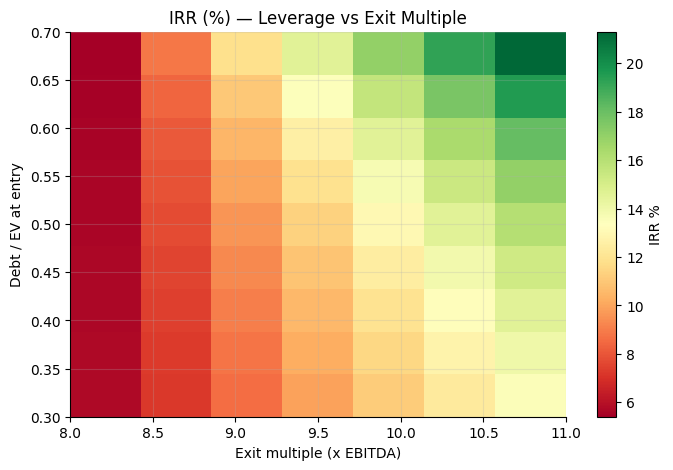

In [37]:
lev_grid = np.arange(0.3, 0.75, 0.05)  # Debt/EV
exit_grid= np.arange(8.0, 11.5, 0.5)

Z = np.zeros((len(lev_grid), len(exit_grid)))
for i, lev in enumerate(lev_grid):
    for j, xm in enumerate(exit_grid):
        r = equity_returns(entry_mult, ebitda1, xm, ebitda_T,
                           debt_in=lev, rate=cost_of_debt, T=term_years,
                           taxes=tax_rate, capex_pct=capex_pct,
                           sales_path=sales_path, nwc_pct=nwc_pct)
        Z[i,j] = r["IRR"]*100

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(Z, origin="lower", cmap="RdYlGn", extent=[exit_grid[0], exit_grid[-1], lev_grid[0], lev_grid[-1]], aspect="auto")
ax.set_xlabel("Exit multiple (x EBITDA)")
ax.set_ylabel("Debt / EV at entry")
ax.set_title("IRR (%) — Leverage vs Exit Multiple")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("IRR %")
plt.show()

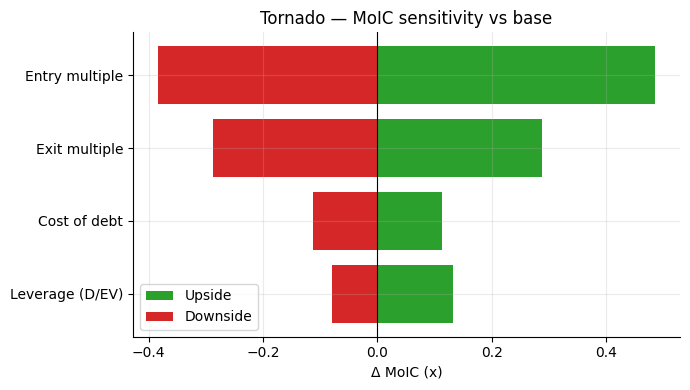

,driver,moic_low,moic_high,span
2,Leverage (D/EV),1.616416,1.827360,0.210944
3,Cost of debt,1.583020,1.808020,0.225000
0,Exit multiple,1.407611,1.983428,0.575817
1,Entry multiple,1.311781,2.181589,0.869808


In [38]:
base = equity_returns(entry_mult, ebitda1, exit_mult, ebitda_T,
                      debt_in=net_debt, rate=cost_of_debt, T=term_years,
                      taxes=tax_rate, capex_pct=capex_pct,
                      sales_path=sales_path, nwc_pct=nwc_pct)["MoIC"]

def bump_moic(param, low, high, **kwargs):
    lo = kwargs.copy(); lo[param]=low
    hi = kwargs.copy(); hi[param]=high
    r_lo = equity_returns(**lo)["MoIC"]
    r_hi = equity_returns(**hi)["MoIC"]
    return r_lo, r_hi

ranges = []
ranges.append(("Exit multiple", *bump_moic("exit_mult", exit_mult-1.0, exit_mult+1.0,
                                           entry_mult=entry_mult, ebitda0=ebitda1,
                                           ebitda_T=ebitda_T, debt_in=net_debt, rate=cost_of_debt,
                                           T=term_years, taxes=tax_rate, capex_pct=capex_pct,
                                           sales_path=sales_path, nwc_pct=nwc_pct)))
ranges.append(("Entry multiple", *bump_moic("entry_mult", entry_mult-1.0, entry_mult+1.0,
                                            exit_mult=exit_mult, ebitda0=ebitda1, ebitda_T=ebitda_T,
                                            debt_in=net_debt, rate=cost_of_debt, T=term_years,
                                            taxes=tax_rate, capex_pct=capex_pct, sales_path=sales_path, nwc_pct=nwc_pct)))
ranges.append(("Leverage (D/EV)", *bump_moic("debt_in", net_debt-0.1, net_debt+0.1,
                                            entry_mult=entry_mult, exit_mult=exit_mult, ebitda0=ebitda1,
                                            ebitda_T=ebitda_T, rate=cost_of_debt, T=term_years,
                                            taxes=tax_rate, capex_pct=capex_pct, sales_path=sales_path, nwc_pct=nwc_pct)))
ranges.append(("Cost of debt", *bump_moic("rate", cost_of_debt-0.02, cost_of_debt+0.02,
                                          entry_mult=entry_mult, exit_mult=exit_mult, ebitda0=ebitda1,
                                          ebitda_T=ebitda_T, debt_in=net_debt, T=term_years,
                                          taxes=tax_rate, capex_pct=capex_pct, sales_path=sales_path, nwc_pct=nwc_pct)))

tornado = pd.DataFrame(ranges, columns=["driver", "moic_low", "moic_high"])
# Ensure low<=high for consistency
tornado[["moic_low","moic_high"]] = np.sort(tornado[["moic_low","moic_high"]].values, axis=1)
tornado["span"] = (tornado["moic_high"] - tornado["moic_low"]).abs()
tornado.sort_values("span", ascending=True, inplace=True)

plt.figure(figsize=(7,4))
plt.barh(tornado["driver"], tornado["moic_high"]-base, color="#2ca02c", label="Upside")
plt.barh(tornado["driver"], tornado["moic_low"]-base, color="#d62728", label="Downside")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Tornado — MoIC sensitivity vs base")
plt.xlabel("Δ MoIC (x)")
plt.legend()
plt.tight_layout(); plt.show()
tornado

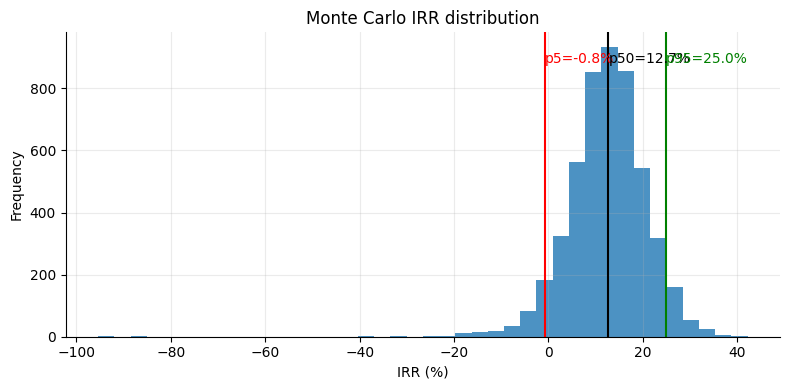

IRR: p5=-0.8%, p50=12.7%, p95=25.0%


In [39]:
N = 5_000
rng = np.random.default_rng(7)

# Randomize key drivers
entry_s  = rng.normal(entry_mult, 0.6, N)
exit_s   = rng.normal(exit_mult, 0.8, N)
lev_s    = np.clip(rng.normal(net_debt, 0.08, N), 0.2, 0.8)
rate_s   = np.clip(rng.normal(cost_of_debt, 0.015, N), 0.03, 0.15)
cagr_s   = np.clip(rng.normal(sales_cagr, 0.02, N), -0.05, 0.15)
uplift_s = np.clip(rng.normal(mg_uplift, 0.01, N), -0.01, 0.05)

irrs = np.zeros(N)
for i in range(N):
    pnl_i = project_pnl(sales0, ebitda_mg0, cagr_s[i], uplift_s[i], term_years)
    ebitda_T_i = pnl_i["ebitda"].iloc[-1]
    r = equity_returns(entry_s[i], ebitda1, exit_s[i], ebitda_T_i,
                       debt_in=lev_s[i], rate=rate_s[i], T=term_years,
                       taxes=tax_rate, capex_pct=capex_pct,
                       sales_path=pnl_i["sales"].iloc[1:].to_numpy(), nwc_pct=nwc_pct)
    irrs[i] = r["IRR"]*100

p5, p50, p95 = np.percentile(irrs, [5,50,95])
plt.figure(figsize=(8,4))
plt.hist(irrs, bins=40, alpha=0.8)
plt.axvline(p5,  color="red");   plt.text(p5, plt.ylim()[1]*0.9, f"p5={p5:.1f}%", color="red")
plt.axvline(p50, color="black"); plt.text(p50,plt.ylim()[1]*0.9, f"p50={p50:.1f}%", color="black")
plt.axvline(p95, color="green"); plt.text(p95,plt.ylim()[1]*0.9, f"p95={p95:.1f}%", color="green")
plt.title("Monte Carlo IRR distribution")
plt.xlabel("IRR (%)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

print(f"IRR: p5={p5:.1f}%, p50={p50:.1f}%, p95={p95:.1f}%")

### Takeaways

- **Multiple & leverage** dominate short-horizon equity IRR, but **operational uplift** (mix, cost, opex) compounds through margin and growth.
- The **value creation waterfall** makes the operating thesis tangible; the **heatmaps** reveal regime risk.
- **Monte Carlo** quantifies downside (p5 IRR) and supports reserve/RCF planning alongside the CVaR buffer from Notebook 2.